In [2]:
from particletracking import dataframes
import numpy as np
import matplotlib.pyplot as plt
from scipy import spatial

/home/ppxjd3/miniconda3/envs/Experiments/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/ppxjd3/miniconda3/envs/Experiments/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/ppxjd3/miniconda3/envs/Experiments/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/ppxjd3/miniconda3/envs/Experiments/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
pi = 3.141

In [4]:
file_name = "/media/data/Data/Orderphobic/StuckIntruders/OneIntruderDifferentDuties/17070009.hdf5"
data = dataframes.DataStore(file_name)

/home/ppxjd3/miniconda3/envs/Experiments/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [5]:
df = data.df

In [6]:
def coarse_order_field(df, cgw, x, y, no_of_neighbours=20):
    """
    Calculate the coarse-grained field characterising local orientation order
    """

    order = df.order.values

    # Generate the lattice nodes to query
    # x, y = np.meshgrid(x, y)
    r = np.dstack((x, y))

    # Get the positions of all the particles
    particles = df[['x', 'y']].values

    # Generate the tree from the particles
    tree = spatial.cKDTree(particles)

    # Query the tree at all the lattice nodes to find the nearest n particles
    # Set n_jobs=-1 to use all cores
    dists, indices = tree.query(r, no_of_neighbours, n_jobs=-1)

    # Calculate all the coarse-grained delta functions (Katira ArXiv eqn 3
    cg_deltas = np.exp(-dists ** 2 / (2 * cgw ** 2)) / (2 * pi * cgw ** 2)

    # Multiply by the orders to get the summands
    summands = cg_deltas * order[indices]

    # Sum along axis 2 to calculate the field
    field = np.sum(summands, axis=2)

    return field

In [7]:
def get_cgw(df):
    tree = spatial.cKDTree(df[['x', 'y']].values)
    dists, _ = tree.query(tree.data, 2)
    cgw = np.mean(dists[:, 1])
    return cgw
cgw = get_cgw(data.df.loc[0]) / 2

In [8]:
from labvision import images

In [9]:
def im_to_unit8(im):
    im *= 255 / np.max(im)
    return np.uint8(im)

In [10]:
import cv2

In [11]:
plt.imshow(field)
plt.plot(POINT[0], POINT[1], 'x')

NameError: name 'field' is not defined

In [12]:
POINT = 200, 150

In [15]:
def disordered_size(df, lattice_spacing=5, i=0):
    x = np.arange(0, max(df.x), lattice_spacing)
    y = np.arange(0, max(df.y), lattice_spacing)
    x, y = np.meshgrid(x, y)
    cgw = get_cgw(df.loc[i]) / 2
    field = coarse_order_field(df.loc[i], cgw, x, y)
    field8 = im_to_unit8(field)
    blur = cv2.blur(field8, (13, 13))
    threshold = images.threshold(blur, np.mean(blur)+np.std(blur)/4)
    contours = images.find_contours(threshold)
    contours = images.sort_contours(contours)
    dists = np.array([cv2.pointPolygonTest(c, POINT, True) for c in contours])
    contours = [c for c, d in zip(contours, dists) if d > 0]
    try:
        area = cv2.contourArea(contours[0])
    except IndexError as e:
        print('no contour')
    return area

In [16]:
def find_disordered_contours(df, lattice_spacing=5, i=0):
    x = np.arange(0, max(df.x), lattice_spacing)
    y = np.arange(0, max(df.y), lattice_spacing)
    x, y = np.meshgrid(x, y)
    cgw = get_cgw(df.loc[i]) / 2
    field = coarse_order_field(df.loc[i], cgw, x, y)
    field8 = im_to_unit8(field)
    blur = cv2.blur(field8, (13, 13))
    threshold = images.threshold(blur, np.mean(blur)+np.std(blur)/4)
    contours = images.find_contours(threshold)
    contours = images.sort_contours(contours)
    dists = np.array([cv2.pointPolygonTest(c, POINT, True) for c in contours])
    contours = [c for c, d in zip(contours, dists) if d > 0]
    return contours

In [17]:
contours = find_disordered_contours(data.df)

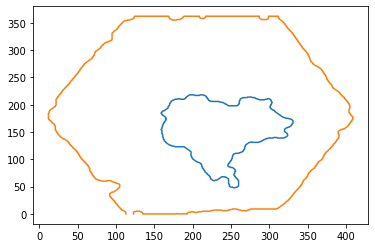

In [18]:
for c in contours:
    plt.plot(c[:, :, 0], c[:, :, 1])

In [21]:
contour = contours[0]

In [22]:
def fluctuations(contour, p):
    dxs = contour[:, :, 0] - p[0]
    dys = contour[:, :, 1] - p[1]
    drs = np.sqrt(dxs**2 + dys**2)
    return drs

In [23]:
drs = fluctuations(contour, POINT)

In [24]:
radius = np.mean(drs)

In [25]:
radius

80.54896541120476

In [26]:
deviation_from_radius = drs - radius

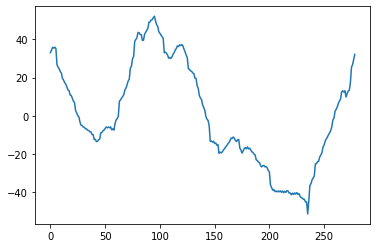

In [27]:
plt.plot(deviation_from_radius)

In [55]:
from shapely.geometry import LineString, Point, MultiPoint

In [32]:
contour.squeeze().shape

(279, 2)

In [33]:
shapely_contour = LineString(contour.squeeze())

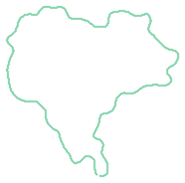

In [34]:
shapely_contour

In [38]:
point = Point(POINT)
circle = point.buffer(radius)

In [82]:
angles = np.linspace(0, 2*pi, 100)

In [83]:
crosses = []
distances = []
for a in angles:
    new_line = LineString((POINT, (POINT[0] + np.cos(a)*4*radius, POINT[1] + np.sin(a)*4*radius)))
    intersections = new_line.intersection(shapely_contour)
    try:
        intersection = intersections[0]
    except TypeError:
        intersection = intersections
    crosses.append(intersection)
    dx = intersection.x - POINT[0] + np.cos(a)*radius
    dy = intersection.y - POINT[1] + np.sin(a)*radius
    distances.append(dx**2 + dy**2)

In [84]:
crosses = MultiPoint(crosses)

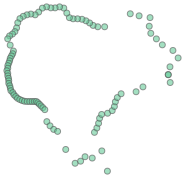

In [85]:
crosses

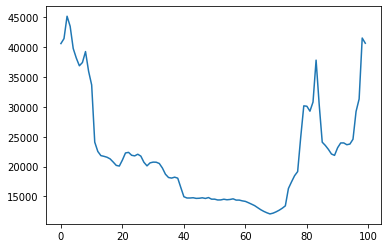

In [86]:
plt.plot(distances)

In [87]:
sp = np.fft.fft(distances)

In [88]:
freq = np.fft.fftfreq(len(sp), d=2*pi*radius/len(sp))

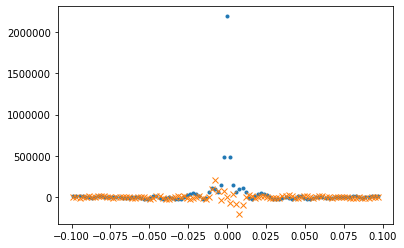

In [89]:
plt.plot(freq, sp.real, '.', freq, sp.imag, 'x')

/home/ppxjd3/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/home/ppxjd3/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


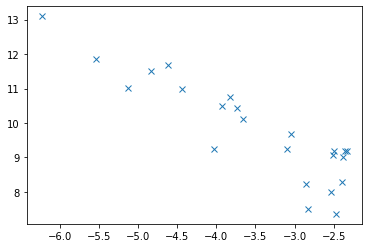

In [90]:
plt.plot(np.log(freq), np.log(sp.real), 'x')

In [163]:
import filehandling

In [164]:
direc = "/media/data/Data/Orderphobic/StuckIntruders/OneIntruderDifferentDuties"
files = filehandling.get_directory_filenames(f'{direc}/*.hdf5')
files

['/media/data/Data/Orderphobic/StuckIntruders/OneIntruderDifferentDuties/17070007.hdf5',
 '/media/data/Data/Orderphobic/StuckIntruders/OneIntruderDifferentDuties/17070008.hdf5',
 '/media/data/Data/Orderphobic/StuckIntruders/OneIntruderDifferentDuties/17070009.hdf5',
 '/media/data/Data/Orderphobic/StuckIntruders/OneIntruderDifferentDuties/17070010.hdf5',
 '/media/data/Data/Orderphobic/StuckIntruders/OneIntruderDifferentDuties/17070011.hdf5',
 '/media/data/Data/Orderphobic/StuckIntruders/OneIntruderDifferentDuties/17070012.hdf5',
 '/media/data/Data/Orderphobic/StuckIntruders/OneIntruderDifferentDuties/17070013.hdf5',
 '/media/data/Data/Orderphobic/StuckIntruders/OneIntruderDifferentDuties/17070014.hdf5',
 '/media/data/Data/Orderphobic/StuckIntruders/OneIntruderDifferentDuties/17070015.hdf5']

In [166]:
data.df.loc[0]['Duty'].mean()

630.0

In [210]:
from tqdm.notebook import tqdm

In [209]:
results = {}
for f in tqdm(files):
    data = dataframes.DataStore(f)
    duty = data.df.loc[0]['Duty'].mean()
    area = [disordered_size(data.df, i=i) for i in range(data.df.index.max())]
    results[duty] = np.mean(area)

/home/ppxjd3/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour
no contour

In [212]:
results

{610.0: 8782.0,
 620.0: 10927.0,
 630.0: 15574.0,
 640.0: 18859.5,
 650.0: 32693.5,
 660.0: 0.0,
 670.0: 0.0,
 680.0: 5394.0,
 690.0: 8273.0}

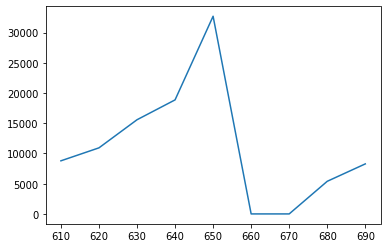

In [213]:
lists = sorted(results.items())
x, y = zip(*lists)
plt.plot(x, y)

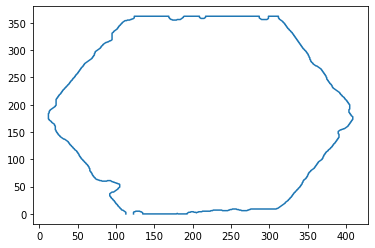

In [216]:
plt.plot(contour[:, :, 0], contour[:, :, 1])

In [238]:
class Contour:
    
    def __init__(self, c):
        self.array = c
        
    def __repr__(self):
        return f"Contour of length {len(self.array)}"
    
    def _repr_png_(self):
        
        
class ContourCollection:
    
    def __init__(self, cc):
        self.contour_list = cc
        
    def get(self, i):
        return Contour(self.contour_list[i])

In [239]:
cc = ContourCollection(contours)

In [240]:
cc.get(1)

Contour of length 678